# Building and Testing the performance of different models for the "Occupation Quota" of a Parisian street

## ----------------------------------- Data loading and Preprocessing -----------------------------------

#### Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import time
import os
import tqdm.notebook as tq
import tensorflow as tf
import warnings
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.layers.normalization import BatchNormalization

#### Connect to Google Drive to get access to data later on

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/'Dossier partagé avec Iheb BELGACEM'/BCG_Hackathon

/content/drive/.shortcut-targets-by-id/1yXfewQDE3qy07N5B0XsOVSfqgaaXT3R7/Dossier partagé avec Iheb BELGACEM/BCG_Hackathon


#### Load dataframe and start preprocessing

In [ ]:
data_path = "datasets/wash1.csv"
TARGET = "Taux d'occupation"
#TARGET = "Débit horaire"
dataframe = pd.read_csv(data_path)
dataframe.drop(["Unnamed: 0","index"], axis = 1 , inplace= True)
def set_date(df):
    df["Date et heure de comptage"] = pd.to_datetime(df["Date et heure de comptage"],format='%Y-%m-%d %H:%M:%S%z')
    return df
dataframe = set_date(dataframe)
dataframe.time = dataframe.time.apply(lambda x : int(x[:2]))
if TARGET == "Taux d'occupation": 
  dataframe.drop(["Débit horaire","mean_debit_horaire_past_week"], axis = 1 , inplace= True)
else : 
  dataframe.drop(["Taux d'occupation","mean_taux_occupation_past_week"], axis = 1 , inplace= True)
dataframe.drop(["Etat trafic","Libelle noeud amont","Libelle noeud aval","date"], axis = 1 , inplace= True)
dataframe

,Date et heure de comptage,Taux d'occupation,weekday,weekofyear,month,year,time,temp,dwpt,rhum,tavg,tmin,tmax,pres,mean_taux_occupation_past_week,taux_occupation_sae,retail_and_recreation_percent_change_from_baseline,confin_0,confin_1,confin_2,couvrefeu,ferie
0,2019-11-14 04:00:00+01:00,3.20167,3,46,11,2019,4,5.1,4.2,94.0,5.6,4.6,6.5,997.9,15.835636,12.289109,96.0,1,0,0,0,0
1,2019-11-14 05:00:00+01:00,3.27389,3,46,11,2019,5,5.3,4.3,93.0,5.6,4.6,6.5,997.9,15.809154,12.289109,96.0,1,0,0,0,0
2,2019-11-14 06:00:00+01:00,5.28222,3,46,11,2019,6,5.5,3.3,86.0,5.6,4.6,6.5,997.9,15.828470,12.289109,96.0,1,0,0,0,0
3,2019-11-14 07:00:00+01:00,9.07722,3,46,11,2019,7,5.2,3.4,88.0,5.6,4.6,6.5,997.9,15.854842,12.289109,96.0,1,0,0,0,0
4,2019-11-14 08:00:00+01:00,15.51111,3,46,11,2019,8,5.2,3.5,89.0,5.6,4.6,6.5,997.9,15.900355,12.289109,96.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331,2020-11-29 20:00:00+01:00,13.09667,6,48,11,2020,20,1.0,-0.9,87.0,2.5,1.0,6.0,1023.0,5.704904,72.933663,34.0,0,0,1,0,0
9332,2020-11-29 21:00:00+01:00,7.50778,6,48,11,2020,21,1.0,-0.9,87.0,2.5,1.0,6.0,1023.0,5.720698,72.933663,34.0,0,0,1,0,0
9333,2020-11-29 22:00:00+01:00,4.38000,6,48,11,2020,22,2.0,0.1,87.0,2.5,1.0,6.0,1023.0,5.733952,72.933663,34.0,0,0,1,0,0
9334,2020-11-29 23:00:00+01:00,2.11500,6,48,11,2020,23,2.0,0.1,87.0,2.5,1.0,6.0,1023.0,5.743793,72.933663,34.0,0,0,1,0,0


In [ ]:
dataframe = dataframe.interpolate() #get rid of NaN values
#dataframe

In [ ]:
dataframe.columns

Index(['Date et heure de comptage', 'Taux d'occupation', 'weekday',
       'weekofyear', 'month', 'year', 'time', 'temp', 'dwpt', 'rhum', 'tavg',
       'tmin', 'tmax', 'pres', 'mean_taux_occupation_past_week',
       'taux_occupation_sae',
       'retail_and_recreation_percent_change_from_baseline', 'confin_0',
       'confin_1', 'confin_2', 'couvrefeu', 'ferie'],
      dtype='object')

In [ ]:
feat_time = ['weekday','weekofyear', 'month', 'year', 'time']
feat_meteo_d = ['tavg','tmin', 'tmax', 'pres']
feat_meteo_h = ['temp', 'dwpt', 'rhum']
feat_conf_fer = ['confin_0','confin_1', 'confin_2', 'couvrefeu', 'ferie']
feat_mean = ['mean_taux_occupation_past_week'] if TARGET =="Taux d'occupation" else ['mean_debit_horaire_past_week']
feat_google = ['retail_and_recreation_percent_change_from_baseline']
feat_covid = ['taux_occupation_sae']

In [ ]:
split_rate = 0.8
i_split = int(dataframe.shape[0] * split_rate)
df_train = dataframe[:i_split]
df_test = dataframe[i_split:]
tt = df_test['Date et heure de comptage']

### Model1 - Feed Forward Network


##### Libraries

In [ ]:
to_scale = ['temp', 'dwpt', 'rhum', 'tavg','tmin', 'tmax', 'pres','taux_occupation_sae','retail_and_recreation_percent_change_from_baseline']
for s in to_scale : 
  dataframe[s] = preprocessing.scale(dataframe[s])
dataframe

,Date et heure de comptage,Taux d'occupation,weekday,weekofyear,month,year,time,temp,dwpt,rhum,tavg,tmin,tmax,pres,mean_taux_occupation_past_week,taux_occupation_sae,retail_and_recreation_percent_change_from_baseline,confin_0,confin_1,confin_2,couvrefeu,ferie
0,2019-11-14 04:00:00+01:00,3.20167,3,46,11,2019,4,-1.122753,-0.546167,1.197244,-1.168406,-0.785542,-1.407489,-2.007366,15.835636,-0.577140,1.226208,1,0,0,0,0
1,2019-11-14 05:00:00+01:00,3.27389,3,46,11,2019,5,-1.094279,-0.526431,1.146397,-1.168406,-0.785542,-1.407489,-2.007366,15.809154,-0.577140,1.226208,1,0,0,0,0
2,2019-11-14 06:00:00+01:00,5.28222,3,46,11,2019,6,-1.065805,-0.723800,0.790472,-1.168406,-0.785542,-1.407489,-2.007366,15.828470,-0.577140,1.226208,1,0,0,0,0
3,2019-11-14 07:00:00+01:00,9.07722,3,46,11,2019,7,-1.108516,-0.704063,0.892165,-1.168406,-0.785542,-1.407489,-2.007366,15.854842,-0.577140,1.226208,1,0,0,0,0
4,2019-11-14 08:00:00+01:00,15.51111,3,46,11,2019,8,-1.108516,-0.684326,0.943011,-1.168406,-0.785542,-1.407489,-2.007366,15.900355,-0.577140,1.226208,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331,2020-11-29 20:00:00+01:00,13.09667,6,48,11,2020,20,-1.706473,-1.552750,0.841319,-1.658667,-1.436873,-1.473547,0.656356,5.704904,1.397328,-0.705718,0,0,1,0,0
9332,2020-11-29 21:00:00+01:00,7.50778,6,48,11,2020,21,-1.706473,-1.552750,0.841319,-1.658667,-1.436873,-1.473547,0.656356,5.720698,1.397328,-0.705718,0,0,1,0,0
9333,2020-11-29 22:00:00+01:00,4.38000,6,48,11,2020,22,-1.564102,-1.355381,0.841319,-1.658667,-1.436873,-1.473547,0.656356,5.733952,1.397328,-0.705718,0,0,1,0,0
9334,2020-11-29 23:00:00+01:00,2.11500,6,48,11,2020,23,-1.564102,-1.355381,0.841319,-1.658667,-1.436873,-1.473547,0.656356,5.743793,1.397328,-0.705718,0,0,1,0,0


###### Prepare data for THIS model, separate training and test set

relu
0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 258)               1806      
_________________________________________________________________
dropout (Dropout)            (None, 258)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               132608    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 258)               132354    
_________________________________________________________________
dropout_2 (Dropout)          (None, 258)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 126)       

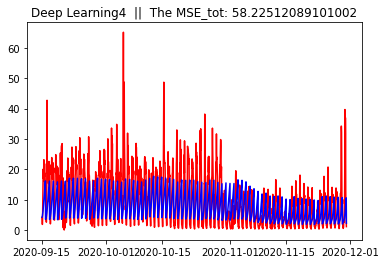

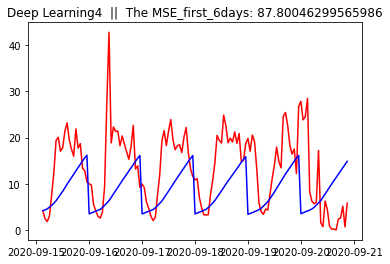

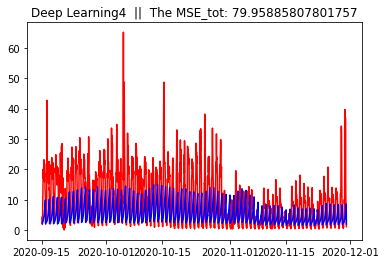

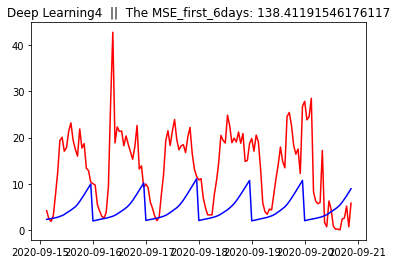

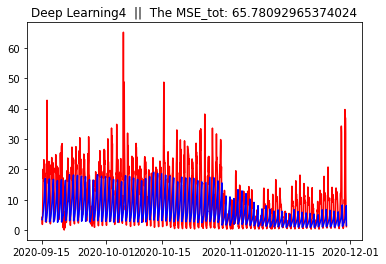

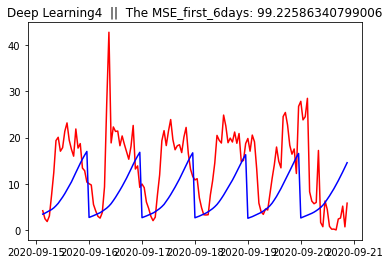

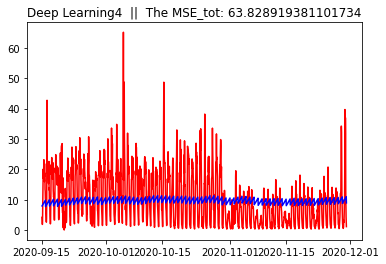

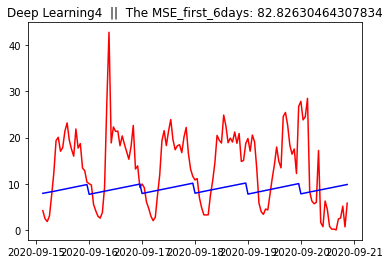

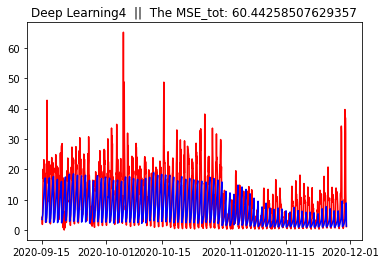

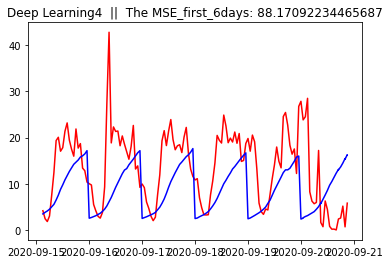

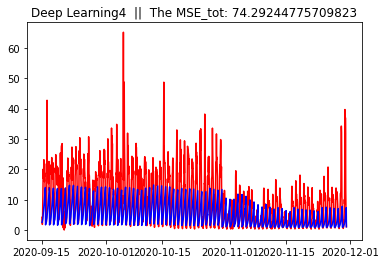

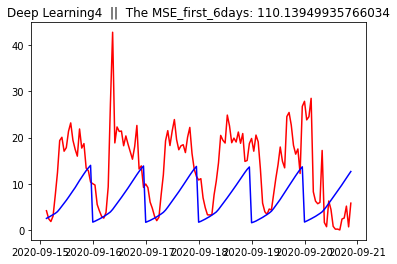

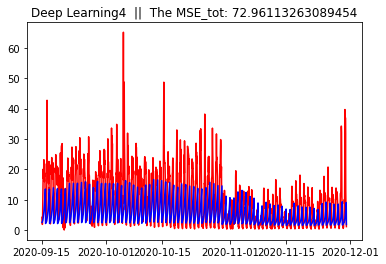

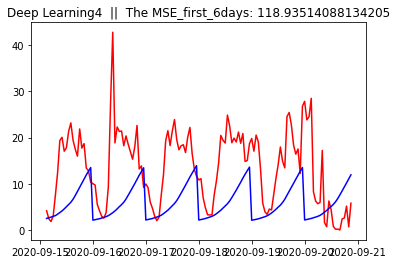

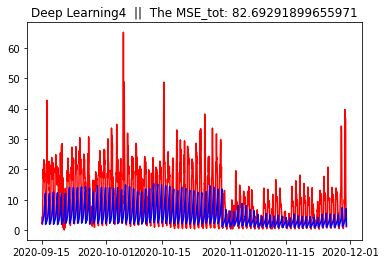

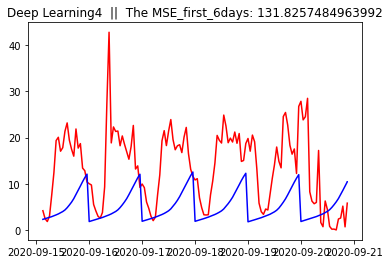

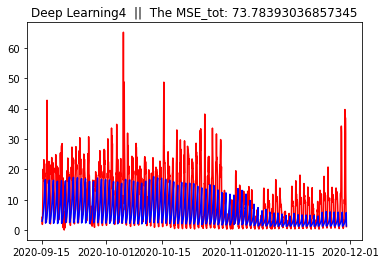

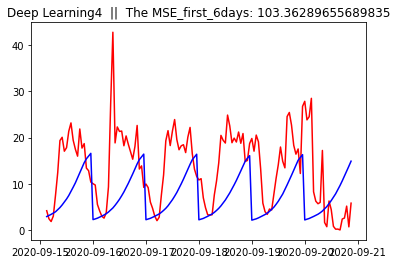

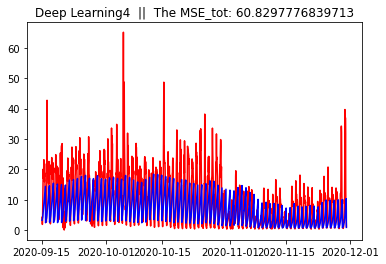

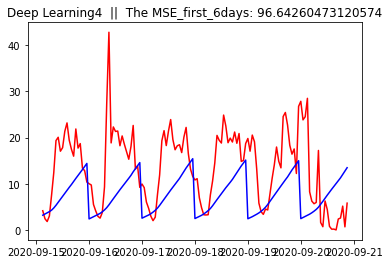

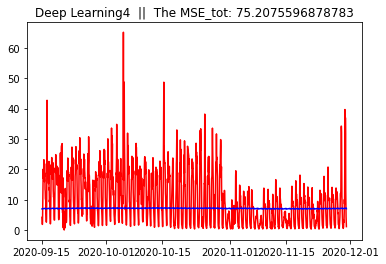

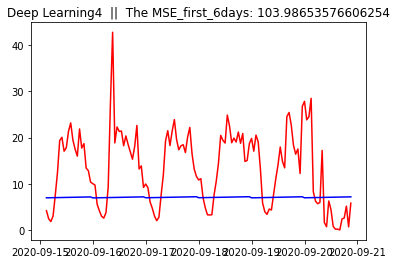

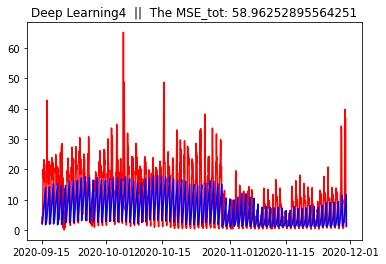

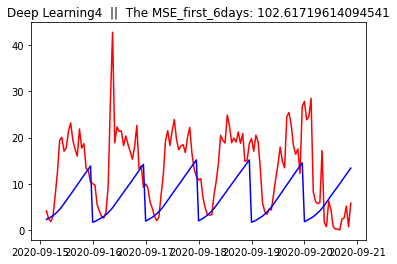

In [ ]:
model_name = "Deep Learning4"
if model_name not in os.listdir(os.getcwd()) : 
  os.mkdir(model_name)
  print('Created Folder')
experiments = [feat_time+feat_mean , feat_time+feat_mean+feat_meteo_d , feat_time+feat_mean+feat_conf_fer,
               feat_time+feat_mean+feat_meteo_d+feat_conf_fer, feat_time+feat_mean+feat_meteo_h+feat_conf_fer,
               feat_time+feat_mean+feat_google, feat_time+feat_mean+feat_meteo_d+feat_google, feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_google,
               feat_time+feat_mean+feat_covid, feat_time+feat_mean+feat_meteo_d+feat_covid, feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_covid,
               feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_covid+feat_google]

count = 1
resume = []
dropout = 0.2
for activation in ["relu"] : 
  for e in tq.tqdm(experiments) : 
    print(activation)
    print(dropout)
    timestep = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
    os.mkdir(os.path.join(os.getcwd(),model_name,timestep))
    x_train =  df_train[e].values
    x_test = df_test[e].values
    y_train = df_train[TARGET].values
    y_test = df_test[TARGET].values
    model1 = Sequential()
    model1.add(Dense(258, activation = activation, input_dim = len(e) ))
    model1.add(Dropout(0.2))
    model1.add(Dense(512, activation = activation))
    model1.add(Dropout(0.2))
    model1.add(Dense(258, activation = activation))
    model1.add(Dropout(0.2))
    model1.add(Dense(126, activation = activation))
    model1.add(Dropout(0.2))
    model1.add(Dense(64, activation = activation))
    model1.add(Dense(1))
    model1.compile(loss = 'mse', optimizer = 'adam')
    model1.summary()
    epochs = 300
    es =tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode ='min',verbose = 1, patience = 20)
    model1.fit(x_train, y_train, epochs = epochs, verbose = 1, validation_split=0.15, callbacks = [es], batch_size = 128)
    pred = model1.predict(x_test)
    mse_tot = mean_squared_error(y_test,pred)
    mse_first = mean_squared_error(y_test[:24*6],pred[:24*6])
    record = {'name' : timestep , 'features' : e, "mse_tot":mse_tot , "mse_first" :mse_first ,"activation" : activation, "dropout" : 0.2, "model" : str(model1.summary()), "path": os.path.join(os.getcwd(), model_name, timestep)}
    resume.append(record)
    pd.DataFrame.from_records([record]).to_csv(os.path.join(os.getcwd(),model_name,timestep,timestep+".csv"))
    fig = plt.figure(count)
    count = count + 1
    plt.plot(tt, y_test , color = 'r',label = 'real values')
    plt.plot(tt, pred , color ='b',label = 'prediected values')
    plt.title(model_name + "  ||  The MSE_tot: {}".format(mse_tot))
    fig.savefig(os.path.join(os.getcwd(),model_name,timestep,'total'+timestep+'.jpeg'))
    fig = plt.figure(count)
    count = count +1 
    plt.plot(tt[:24*6], y_test[:24*6] , color = 'r',label = 'real values')
    plt.plot(tt[:24*6], pred[:24*6] , color = 'b',label = 'predicted values')
    plt.title(model_name + "  ||  The MSE_first_6days: {}".format(mse_first))
    fig.savefig(os.path.join(os.getcwd(), model_name,timestep,'first'+timestep+'.jpeg'))
pd.DataFrame.from_records(resume).sort_values('mse_tot').to_csv(model_name+".csv")
resume = pd.read_csv(model_name+'.csv')
del resume['Unnamed: 0']

In [ ]:
resume

,name,features,mse_tot,mse_first,activation,dropout,model,path
0,2020-12-09 02_22_00,"['weekday', 'weekofyear', 'month', 'year', 'ti...",58.225121,87.800463,relu,0.2,None,/content/drive/.shortcut-targets-by-id/1yXfewQ...
1,2020-12-09 02_23_31,"['weekday', 'weekofyear', 'month', 'year', 'ti...",58.962529,102.617196,relu,0.2,None,/content/drive/.shortcut-targets-by-id/1yXfewQ...
2,2020-12-09 02_22_34,"['weekday', 'weekofyear', 'month', 'year', 'ti...",60.442585,88.170922,relu,0.2,None,/content/drive/.shortcut-targets-by-id/1yXfewQ...
3,2020-12-09 02_23_18,"['weekday', 'weekofyear', 'month', 'year', 'ti...",60.829778,96.642605,relu,0.2,None,/content/drive/.shortcut-targets-by-id/1yXfewQ...
4,2020-12-09 02_22_29,"['weekday', 'weekofyear', 'month', 'year', 'ti...",63.828919,82.826305,relu,0.2,None,/content/drive/.shortcut-targets-by-id/1yXfewQ...
5,2020-12-09 02_22_21,"['weekday', 'weekofyear', 'month', 'year', 'ti...",65.780930,99.225863,relu,0.2,None,/content/drive/.shortcut-targets-by-id/1yXfewQ...
6,2020-12-09 02_22_51,"['weekday', 'weekofyear', 'month', 'year', 'ti...",72.961133,118.935141,relu,0.2,None,/content/drive/.shortcut-targets-by-id/1yXfewQ...
7,2020-12-09 02_23_09,"['weekday', 'weekofyear', 'month', 'year', 'ti...",73.783930,103.362897,relu,0.2,None,/content/drive/.shortcut-targets-by-id/1yXfewQ...
8,2020-12-09 02_22_42,"['weekday', 'weekofyear', 'month', 'year', 'ti...",74.292448,110.139499,relu,0.2,None,/content/drive/.shortcut-targets-by-id/1yXfewQ...
9,2020-12-09 02_23_27,"['weekday', 'weekofyear', 'month', 'year', 'ti...",75.207560,103.986536,relu,0.2,None,/content/drive/.shortcut-targets-by-id/1yXfewQ...


In [ ]:
for i in range(10) : 
  print(i)
  print("MSE_tot: {}    ||     Features: {}".format( str(resume.loc[i,"mse_tot"]), resume.loc[i,'features']))

0
MSE_tot: 58.22512089101003    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week']
1
MSE_tot: 58.96252895564251    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'tavg', 'tmin', 'tmax', 'pres', 'confin_0', 'confin_1', 'confin_2', 'couvrefeu', 'ferie', 'taux_occupation_sae', 'retail_and_recreation_percent_change_from_baseline']
2
MSE_tot: 60.442585076293575    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'temp', 'dwpt', 'rhum', 'confin_0', 'confin_1', 'confin_2', 'couvrefeu', 'ferie']
3
MSE_tot: 60.8297776839713    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'tavg', 'tmin', 'tmax', 'pres', 'taux_occupation_sae']
4
MSE_tot: 63.82891938110172    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'tavg', 'tmin', 'tmax', 'p

name                                        2020-12-09 02_22_00
features      ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                 58.2251
mse_first                                               87.8005
activation                                                 relu
dropout                                                     0.2
model                                                      None
path          /content/drive/.shortcut-targets-by-id/1yXfewQ...
Name: 0, dtype: object


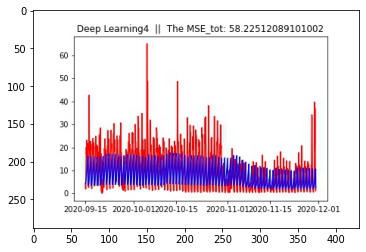

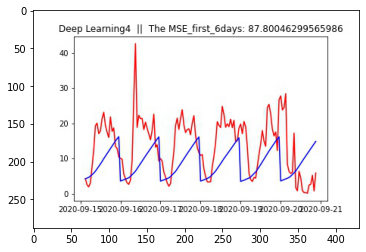

name                                        2020-12-09 02_23_31
features      ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                 58.9625
mse_first                                               102.617
activation                                                 relu
dropout                                                     0.2
model                                                      None
path          /content/drive/.shortcut-targets-by-id/1yXfewQ...
Name: 1, dtype: object


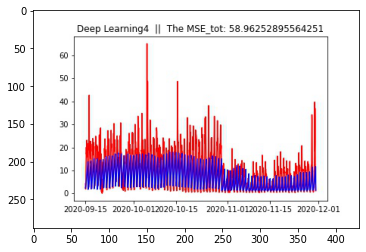

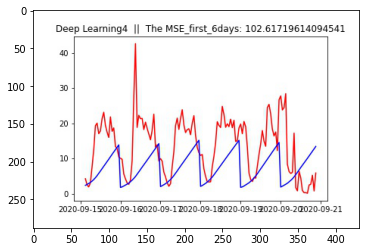

name                                        2020-12-09 02_22_34
features      ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                 60.4426
mse_first                                               88.1709
activation                                                 relu
dropout                                                     0.2
model                                                      None
path          /content/drive/.shortcut-targets-by-id/1yXfewQ...
Name: 2, dtype: object


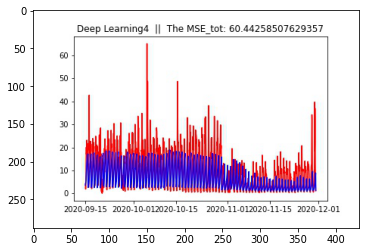

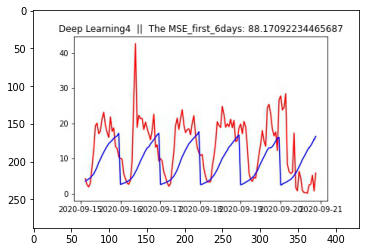

name                                        2020-12-09 02_23_18
features      ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                 60.8298
mse_first                                               96.6426
activation                                                 relu
dropout                                                     0.2
model                                                      None
path          /content/drive/.shortcut-targets-by-id/1yXfewQ...
Name: 3, dtype: object


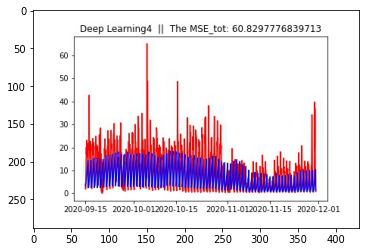

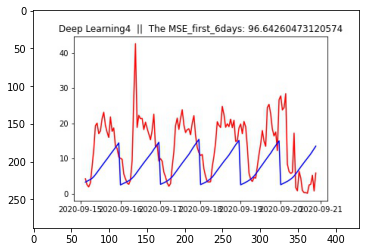

name                                        2020-12-09 02_22_29
features      ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                 63.8289
mse_first                                               82.8263
activation                                                 relu
dropout                                                     0.2
model                                                      None
path          /content/drive/.shortcut-targets-by-id/1yXfewQ...
Name: 4, dtype: object


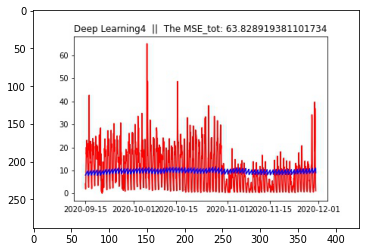

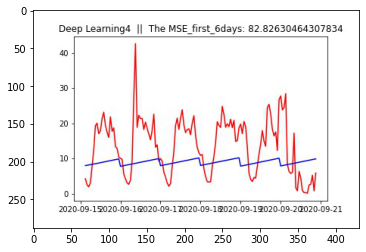

In [ ]:
for i in range(5) : 
  print(resume.loc[i])
  path = resume.loc[i,"path"]
  for file in os.listdir(path) :
    if '.jpeg' in file : 
      img = mpimg.imread(os.path.join(resume.loc[i,'path'],file))
      plt.imshow(img)
      plt.show()